# cMLP Lagged VAR Demo

- In this notebook, we train a cMLP model on linear VAR data with lagged interactions.
- After examining the Granger causality discovery, we train a debiased model using only the discovered interactions.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96
from models.cmlp import cMLP, cMLPSparse, train_model_ista, train_unregularized

In [2]:
# For GPU acceleration
device = torch.device('cuda')

In [3]:
# Simulate data
p = 10
X_np, GC = simulate_lorenz_96(p=p, F=5, T=1000, delta_t=1)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)
for i in range(p):
    GC[i][i] = 0

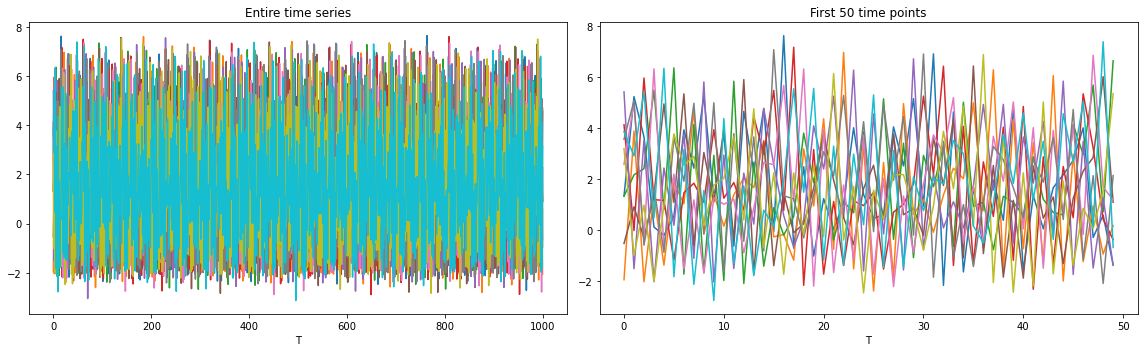

In [4]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

# Still need to tune $\lambda$ and perhaps lr

In [5]:
# Set up model
cmlp = cMLP(X.shape[-1], lag=1, hidden=[100]).cuda(device=device)

In [6]:
# Train with ISTA
train_loss_list = train_model_ista(
    cmlp, X, lam=2.5, lam_ridge=0.008, lr=5e-4, penalty='H', max_iter=100000,
    check_every=100)

----------Iter = 100----------
Loss = 44.236759
Variable usage = 100.00%
----------Iter = 200----------
Loss = 40.755947
Variable usage = 100.00%
----------Iter = 300----------
Loss = 37.538479
Variable usage = 100.00%
----------Iter = 400----------
Loss = 34.400620
Variable usage = 100.00%
----------Iter = 500----------
Loss = 31.305149
Variable usage = 100.00%
----------Iter = 600----------
Loss = 28.240564
Variable usage = 100.00%
----------Iter = 700----------
Loss = 25.204550
Variable usage = 100.00%
----------Iter = 800----------
Loss = 22.199232
Variable usage = 100.00%
----------Iter = 900----------
Loss = 19.229601
Variable usage = 100.00%
----------Iter = 1000----------
Loss = 16.303633
Variable usage = 100.00%
----------Iter = 1100----------
Loss = 13.434142
Variable usage = 100.00%
----------Iter = 1200----------
Loss = 10.643486
Variable usage = 100.00%
----------Iter = 1300----------
Loss = 7.977072
Variable usage = 100.00%
----------Iter = 1400----------
Loss = 5.578155


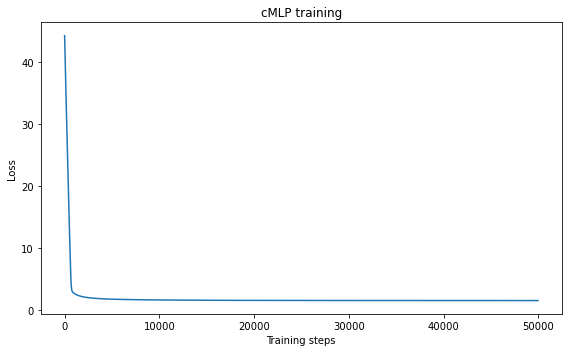

In [7]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

True variable usage = 30.00%
Estimated variable usage = 52.00%
Accuracy = 42.00%


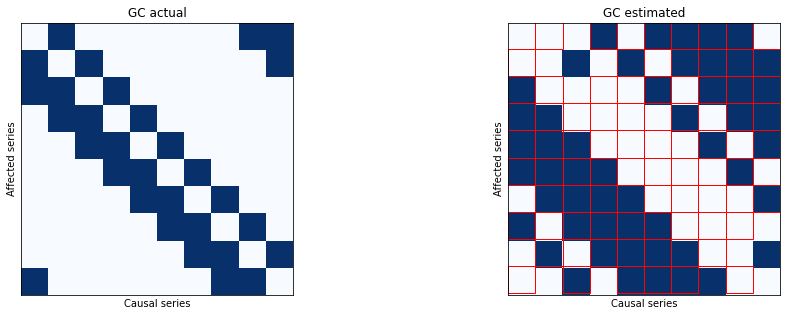

In [8]:
# Verify learned Granger causality
GC_est = cmlp.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()

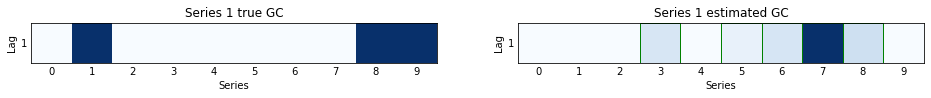

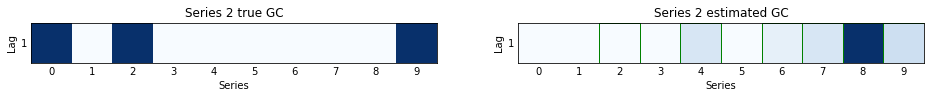

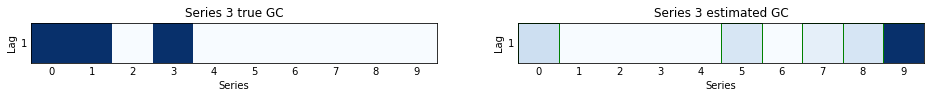

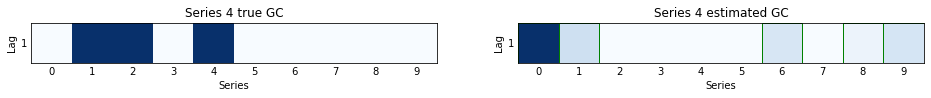

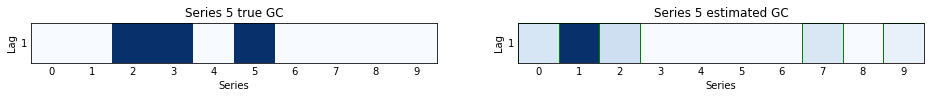

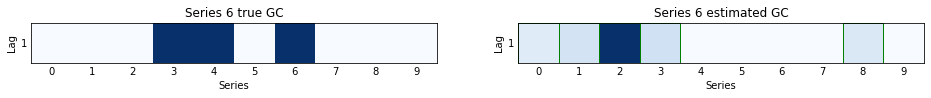

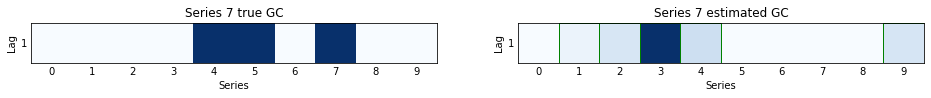

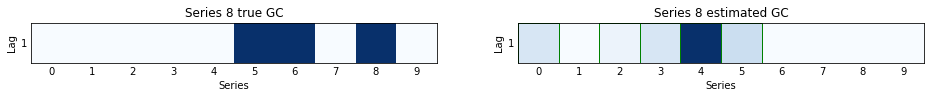

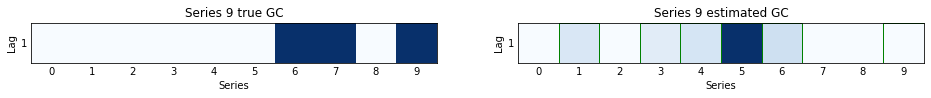

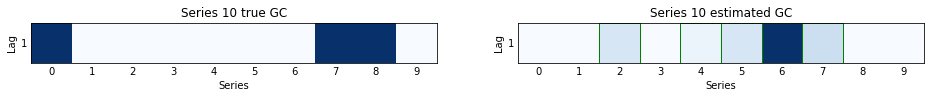

In [9]:
# Verify lag selection
for i in range(len(GC_est)):
    # Get true GC
    GC_lag = np.zeros((1, len(GC_est)))
    GC_lag[:3, GC[i].astype(bool)] = 1.0

    # Get estimated GC
    GC_est_lag = cmlp.GC(ignore_lag=False, threshold=False)[i].cpu().data.numpy().T[::-1]

    # Make figures
    fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
    axarr[0].imshow(GC_lag, cmap='Blues', extent=(0, len(GC_est), 1, 0))
    axarr[0].set_title('Series %d true GC' % (i + 1))
    axarr[0].set_ylabel('Lag')
    axarr[0].set_xlabel('Series')
    axarr[0].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[0].set_xticklabels(range(len(GC_est)))
    axarr[0].set_yticks(np.arange(1) + 0.5)
    axarr[0].set_yticklabels(range(1, 1 + 1))
    axarr[0].tick_params(axis='both', length=0)

    axarr[1].imshow(GC_est_lag, cmap='Blues', extent=(0, len(GC_est), 1, 0))
    axarr[1].set_title('Series %d estimated GC' % (i + 1))
    axarr[1].set_ylabel('Lag')
    axarr[1].set_xlabel('Series')
    axarr[1].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[1].set_xticklabels(range(len(GC_est)))
    axarr[1].set_yticks(np.arange(1) + 0.5)
    axarr[1].set_yticklabels(range(1, 1 + 1))
    axarr[1].tick_params(axis='both', length=0)

    # Mark nonzeros
    for i in range(len(GC_est)):
        for j in range(1):
            if GC_est_lag[j, i] > 0.0:
                rect = plt.Rectangle((i, j), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
                axarr[1].add_patch(rect)

    plt.show()

# Train sparsified model

In [10]:
# Create a debiased model
sparsity = cmlp.GC().bool()
cmlp_sparse = cMLPSparse(X.shape[-1], sparsity, lag=1, hidden=[100]).cuda(device=device)

# Train
train_loss_list = train_unregularized(cmlp_sparse, X, lr=1e-3, max_iter=10000,
                                      check_every=100, verbose=1)

----------Iter = 100----------
Loss = 0.467224
----------Iter = 200----------
Loss = 0.238854
----------Iter = 300----------
Loss = 0.198466
----------Iter = 400----------
Loss = 0.177455
----------Iter = 500----------
Loss = 0.162780
----------Iter = 600----------
Loss = 0.151798
----------Iter = 700----------
Loss = 0.143424
----------Iter = 800----------
Loss = 0.137189
----------Iter = 900----------
Loss = 0.132148
----------Iter = 1000----------
Loss = 0.128020
----------Iter = 1100----------
Loss = 0.124313
----------Iter = 1200----------
Loss = 0.120898
----------Iter = 1300----------
Loss = 0.117839
----------Iter = 1400----------
Loss = 0.115000
----------Iter = 1500----------
Loss = 0.112373
----------Iter = 1600----------
Loss = 0.109935
----------Iter = 1700----------
Loss = 0.107532
----------Iter = 1800----------
Loss = 0.105309
----------Iter = 1900----------
Loss = 0.103029
----------Iter = 2000----------
Loss = 0.101062
----------Iter = 2100----------
Loss = 0.099218
-

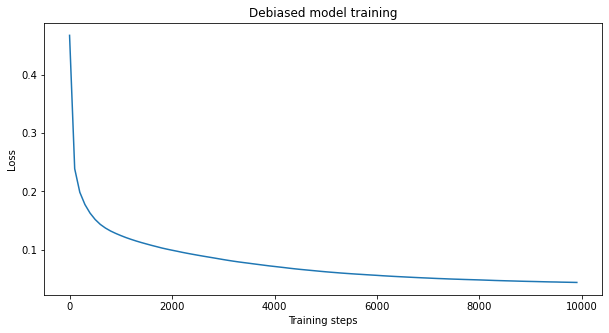

In [11]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.title('Debiased model training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.plot(100 * np.arange(len(train_loss_list)), train_loss_list)
plt.show()